In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display


# 鑑黃大師 (pytorch)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'tensorflow'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import efficientnet

trident 0.5.6
Using TensorFlow backend.
Image Data Format: channels_last.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:7.1.2.


Tensorflow version:2.2.0.
use device:PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU').
executing_eagerly


![Alt text](../images/porndetector.jpg)

![Alt text](../images/pornclass.jpg)

In [3]:
dataset=load_examples_data('nsfw')
dataset.image_transform_funcs=[
    random_adjust_gamma(gamma=(0.8,1.2)),
    #隨機調整圖片明暗gamma 0.6~1.4之間
    random_adjust_contrast(scale=(0.8, 1.2)),
    #隨機調整圖片對比度
    random_adjust_hue(),
    #隨機調整色相
    add_noise(intensity=np.random.choice(np.arange(0.001,0.1,0.0005))),
    #隨機加入噪音
    random_center_crop(224,224,scale=(0.9,1.1)),
    normalize(0, 255),  
    normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

#數據集的圖片處理流程image_transform_funcs為標準imagenet標準化
#加上隨機調整色相random_adjust_hue以及隨機等比例縮放中心裁切random_center_crop

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
training images: 10001  test images:5746
Mapping class_names  in en-us   success, total 5 class names added.
Mapping class_names  in zh-tw   success, total 5 class names added.
Mapping class_names  in zh-cn   success, total 5 class names added.


![Alt text](../images/nsfw_data.jpg)

![Alt text](../images/EfficientNet.jpg)

In [4]:
#獲取EfficientNet-B0預訓練模型
#將全連接層長度改為5
effb0=efficientnet.EfficientNetB0(include_top=True,
             pretrained=True,
             input_shape=(224,224,3),
             classes=5)

#只開放全連接層以及最後一組Efficient Block開放學習
effb0.model.trainable=False
effb0.model.fc.trainable=True
effb0.model.block7a.trainable=True


model file is already existing, donnot need download again.
723637 parameters have set untrainable
6405 parameters have set trainable
717232 parameters have set trainable


In [5]:
#召回率
def recall(output,target):
    input_tensor=squeeze(argmax(output,-1))#將預測結果透過argmax，產生類別的判斷
    target_tensor=squeeze(argmax(target,-1))#將答案標籤透過argmax，產生類別的判斷
    input_tensor=equal(input_tensor,3) #檢查那些預測結果是3(色情圖片)
    target_tensor=equal(target_tensor,3) #檢查那些答案是3(色情圖片)
    metric=reduce_sum(input_tensor*target_tensor)/clip(reduce_sum(target_tensor),1)
    return metric

#input_tensor*target_tensor兩個相乘結果為1，則表示實際是色情圖片且正確被預測
#除以所有的色情圖片總數target_tensor.sum()就可以獲得召回率

In [6]:
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_epoch_start(self, training_context):
        if training_context['current_epoch']==2:
            training_context['current_model'].block6d.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==10:
            training_context['current_model'].block6c.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==15:
            training_context['current_model'].block6b.trainable=True #透過training_context切換模型指定層的trainable狀態
    

In [7]:
effb0=effb0\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_loss(F1ScoreLoss(beta=0.5),name='f1_score')\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(recall,name='recall')\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')\
    .with_model_save_path('Models/effb0_v2_tf.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-4,warmup=0)\
    .with_callbacks(CustomCallback())

#指定優化器(使用Ranger)
#設定損失函數(交叉熵)
#設定評估函數(正確率與召回率)
#設定l2正則化
#設定max_min_norm權重約束
#指定模型存檔位置
#指定學習速率調整機制


effb0.summary()
#檢視模型結構

CrossEntropyLoss( output, target) -> CrossEntropyLoss 
f1_score( output, target) -> f1_score 
accuracy( output, target) -> accuracy 
recall( output, target) -> recall 
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
conv2d_1                                 [-1, 112, 112, 32]       [3, 3, 3, 32]                 864      21663488.0 
batch_norm_1                             [-1, 112, 112, 32]            [32]           [32]       64      1191680.0  
stem                                     [-1, 112, 112, 32]                                      0          0.0     
block1a_dwconv                           [-1, 112, 112, 32]                                      0          0.0     
batch_norm_2                             [-1, 112, 112, 32]            [32]           [32]       64      1191680.0  
a

In [8]:
#設定學習計畫
#指定資料提供者
#跑10個epoach
#minibatch_size為16
#每10個批次列印一次訓練進度
#每100個批次顯示一次loss_metric_curve
#每10個批次存檔一次
plan=TrainingPlan()\
    .add_training_item(effb0)\
    .with_data_loader(dataset)\
    .repeat_epochs(15)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .save_model_scheduling(10,unit='batch')

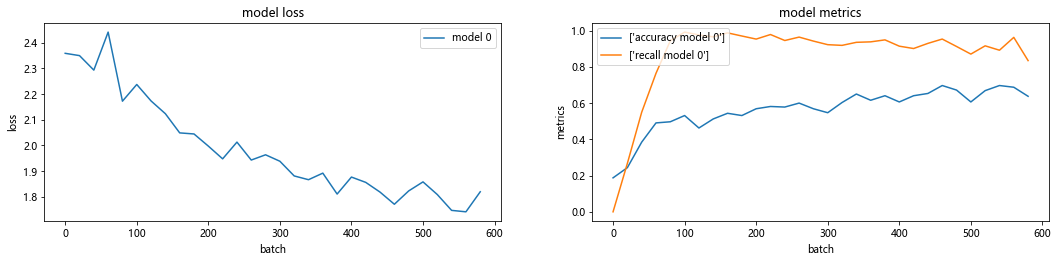

model 0      Step: 27s243ms | Loss: 1.709   | accuracy: 68.125% ,recall: 90.926%  | learning rate: 1.000e-03 | epoch: 0  ( 600/626 )
model 0      Step: 41s888ms | Loss: 1.754   | accuracy: 67.813% ,recall: 90.310%  | learning rate: 1.000e-03 | epoch: 0  ( 620/626 )
model 0: out-of-sample evaluation:  accuracy: 81.250% ,recall: 100.000%
model 0      Step: 19s129ms | Loss: 1.853   | accuracy: 61.458% ,recall: 85.787%  | learning rate: 1.000e-03 | epoch: 1  ( 0/626 )
{ total_losses: 1.85320246219635, CrossEntropyLoss: 0.8686924576759338, f1_score: 0.889901876449585, l2_reg_Loss: 0.004084379877895117 }
model 0      Step: 50s63ms  | Loss: 1.711   | accuracy: 70.625% ,recall: 93.210%  | learning rate: 1.000e-03 | epoch: 1  ( 20/626 )
model 0      Step: 44s641ms | Loss: 1.767   | accuracy: 66.562% ,recall: 85.367%  | learning rate: 1.000e-03 | epoch: 1  ( 40/626 )
model 0      Step: 54s854ms | Loss: 1.733   | accuracy: 71.250% ,recall: 91.384%  | learning rate: 1.000e-03 | epoch: 1  ( 60/626 

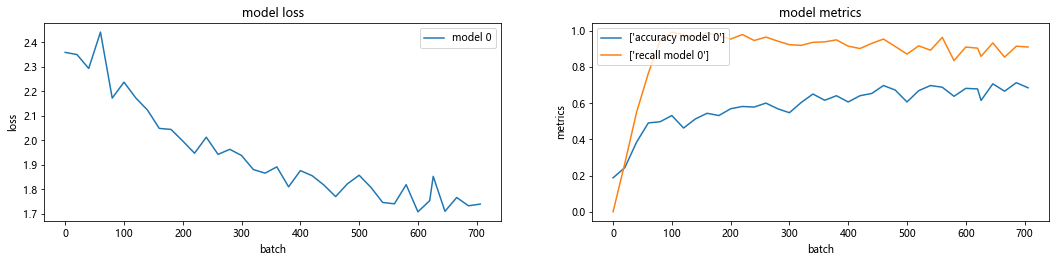

model 0      Step: 49s558ms | Loss: 1.733   | accuracy: 70.938% ,recall: 92.705%  | learning rate: 1.000e-03 | epoch: 1  ( 100/626 )
model 0      Step: 46s726ms | Loss: 1.780   | accuracy: 66.562% ,recall: 89.482%  | learning rate: 1.000e-03 | epoch: 1  ( 120/626 )
model 0      Step: 46s806ms | Loss: 1.755   | accuracy: 70.000% ,recall: 91.280%  | learning rate: 1.000e-03 | epoch: 1  ( 140/626 )


In [ ]:
#執行訓練
plan.start_now()

In [ ]:
effb0.class_names=dataset.class_names['zh-tw']

In [ ]:
img=read_image('../images/venus.jpg')
print(effb0.infer_single_image('../images/venus.jpg',3))
img

In [ ]:
img=read_image('../images/sumo.jpg')
print(effb0.infer_single_image('../images/sumo.jpg',3))
img

In [ ]:
img=read_image('../images/beckham.jpg')
print(effb0.infer_single_image('../images/beckham.jpg',3))
img

In [ ]:
img=read_image('../images/nami.jpg')
print(effb0.infer_single_image('../images/nami.jpg',3))
img

In [ ]:
img=read_image('../images/pornhub.jpg')
img